In [4]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.nn.parameter import Parameter
from torchmetrics import PeakSignalNoiseRatio
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import datetime, random, os, glob
import argparse
from utils import Custom_Dataset, CT_testset

from torchvision.utils import make_grid

2023-12-19 18:57:43.542028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 18:57:43.542067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 18:57:43.542763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 18:57:43.547632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 18:57:44.075688: W tensorflow/compiler/tf2

tensor(0.1668) tensor(0.9725) tensor(0.)
torch.Size([4, 1, 128, 128])


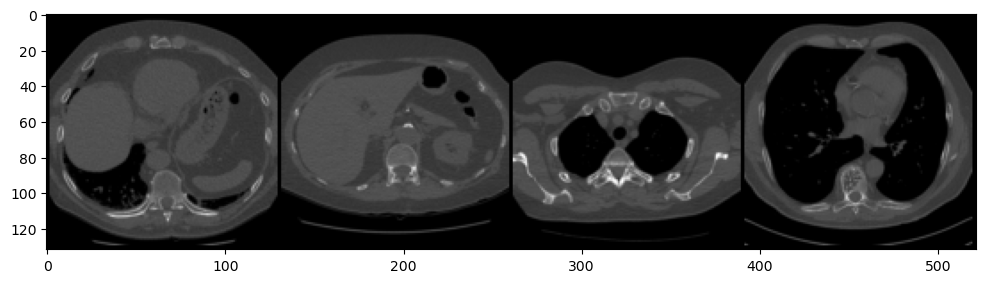

In [1]:
from utils import Custom_Dataset, CT_Dataset
from torch.utils.data import DataLoader
import torch, torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

data_dir    = '/nas/dataset/users/minhyeok/LDCT'
size = 128
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(448),
    torchvision.transforms.Resize(size),
    # torchvision.transforms.RandomCrop(32, padding=4),
    # torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.5, ), (0.5, ))
    ])
batch = 4
train_set = CT_Dataset(data_dir, transform=transforms_train, ww=1800, wl=400)
test_set = CT_Dataset(data_dir, transform=transforms_train, train=False)
dl_train = DataLoader(dataset=train_set, batch_size=batch, drop_last=True, shuffle=True)
dl_test = DataLoader(dataset=test_set, batch_size=batch, drop_last=True, shuffle=True)

image, _ = next(iter(dl_train))
high, low = next(iter(dl_test))
plt.figure(figsize=(12,8))
plt.imshow(make_grid(image, normalize=True).permute(1,2,0))
print(torch.mean(image), torch.max(image), torch.min(image))
print(image.shape)

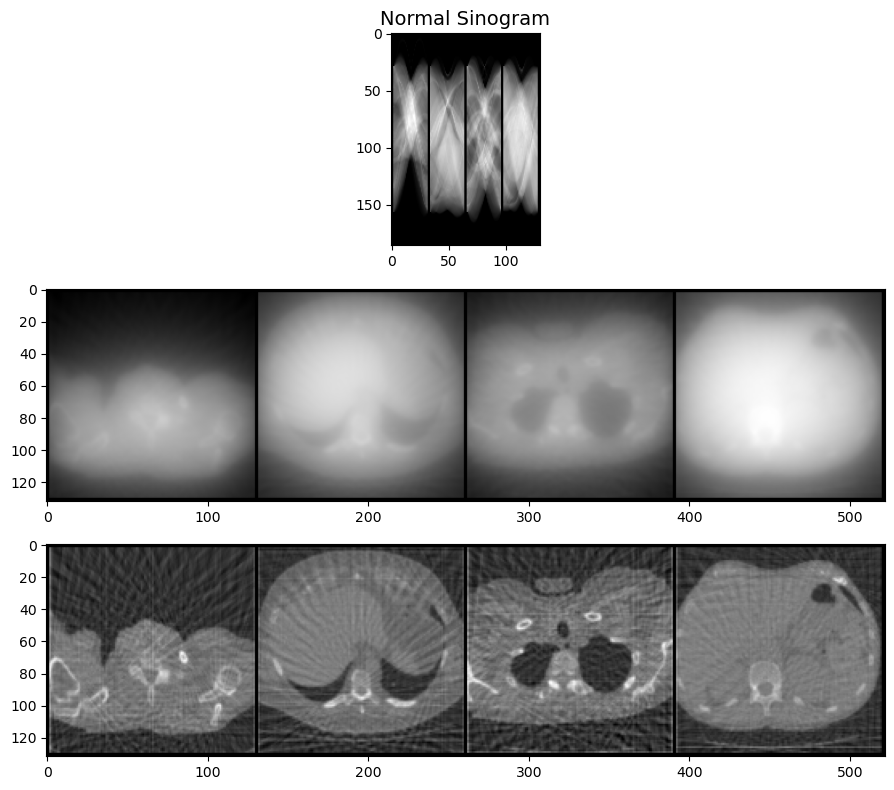

In [9]:
from physics.ct import CT

num_proj = 30
radon = CT(img_width=size, radon_view=num_proj, circle=False)
sinogram = radon.A(image)
blur = radon.AT(sinogram)
sparse = radon.A_filter(sinogram)

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.imshow(make_grid(sinogram, normalize=True).permute(1,2,0))
plt.title('Normal Sinogram', fontsize=14)
plt.subplot(3,1,2)
plt.imshow(make_grid(blur, normalize=True).permute(1,2,0))
plt.subplot(3,1,3)
plt.imshow(make_grid(sparse, normalize=True).permute(1,2,0))
plt.tight_layout()

plt.show()

In [ ]:
from physics.ct import CT

radon_all = CT(img_width=128, radon_view=180, circle=False)
hs = radon_all.A(high)
ls = radon_all.A(low)
dif = hs - ls
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(make_grid(hs[0], normalize=True).permute(1,2,0))
plt.title('Normal Sinogram', fontsize=14)
plt.text(5, 15, '(a)', color='white', fontsize=12)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(make_grid(ls[0], normalize=True).permute(1,2,0))
plt.title('Artifact Sinogram', fontsize=14)
plt.axis('off')
plt.text(5, 15, '(b)', color='white', fontsize=12)
plt.subplot(1,3,3)
plt.imshow(make_grid(dif[0], normalize=True).permute(1,2,0))
plt.title('Residual Sinogram', fontsize=14)
plt.text(5, 15, '(c)', color='white', fontsize=12)
plt.axis('off')
plt.tight_layout()

plt.show()

(-0.5, 179.5, 181.5, -0.5)

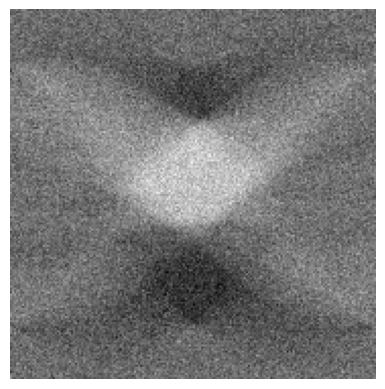

In [165]:
# bts = ls * (1. - dif)
gau = torch.randn(ls.shape) * 20.
gau += ls
plt.imshow(make_grid(gau[0], normalize=True).permute(1,2,0))
plt.axis('off')

(-0.5, 179.5, 181.5, -0.5)

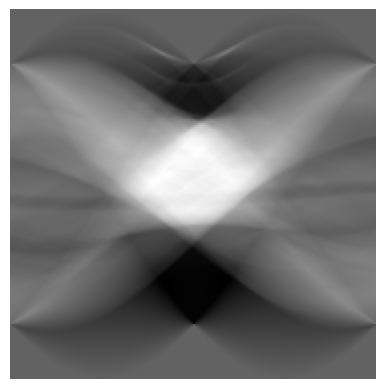

In [154]:

from UNet_model import UNet
from physics.ct import CT

unet = UNet(in_channel=1, dim_feature=32, out_channel=1, bilinear=True)
unet.load_state_dict(torch.load('/nas/users/minhyeok/CMH/sde/result/11_10/sinogram/model_ckpt_80.pth'))
unet = unet.eval()
import torch.nn.functional as F

radon_all = CT(img_width=128, radon_view=180, circle=False)
sinogram_full = radon_all.A(low)
with torch.no_grad():
    diff = unet(sinogram_full)
# mask = F.normalize(diff, dim=0)
# plt.subplot(1,2,1)
# plt.imshow(make_grid(low, normalize=True).permute(1,2,0))
# plt.subplot(1,2,2)

plt.imshow(make_grid(ls, normalize=True).permute(1,2,0))
plt.axis('off')


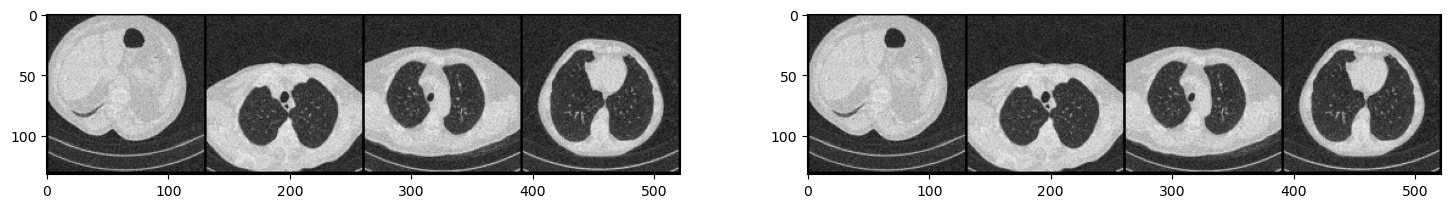

In [19]:
diff = high - low
gau = torch.randn_like(low) * 0.1
ones = torch.ones_like(high)
x1 = high-gau
x2 = (high-gau)/ones

plt.figure(figsize=(18,12))
plt.subplot(1,2,1)
plt.imshow(make_grid(x1, normalize=True).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(make_grid(x2, normalize=True).permute(1,2,0))



In [3]:
from physics.ct import CT
from UNet_model import UNet

radon = CT(img_width=128, radon_view=30, circle=False)
radon_all = CT(img_width=128, radon_view=180, circle=False)
unet = UNet(in_channel=1, dim_feature=32, out_channel=1, bilinear=True)
unet.load_state_dict(torch.load('/nas/users/minhyeok/CMH/sde/result/11_10/sinogram/model_ckpt_80.pth'))
unet = unet.eval()

/hdd1/anaconda/minhyeok/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor(1.0000) tensor(0.0674) tensor(-0.9976)


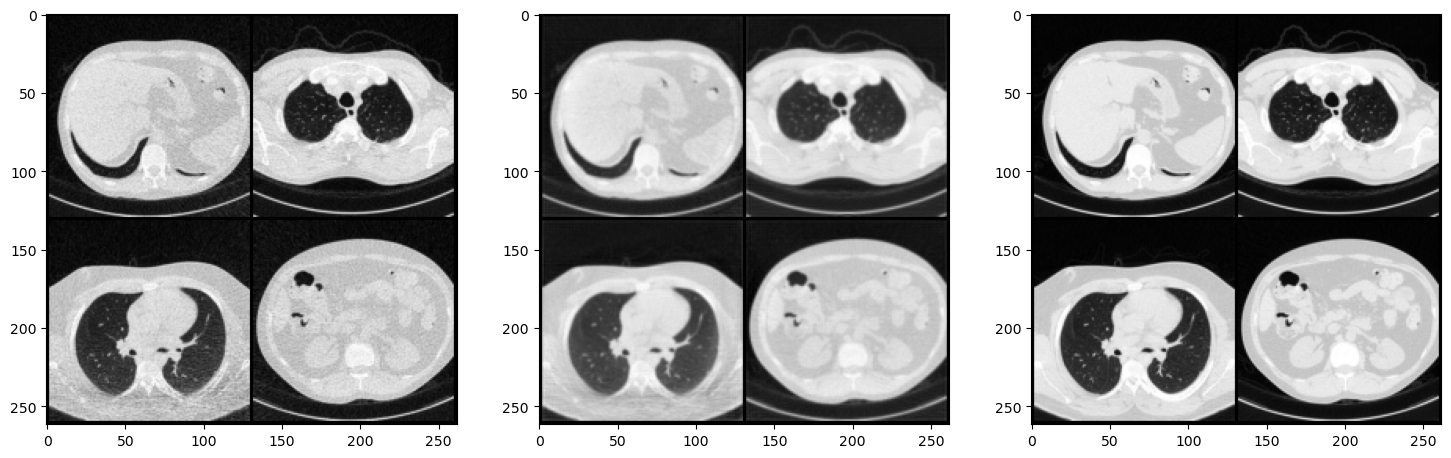

In [40]:
high, low = next(iter(dl_test))
# from skimage.transform import radon, rescale, iradon, iradon_sart
# from skimage.transform.radon_transform import _get_fourier_filter
mask_ori= torch.zeros([4, 1, int((128 * (2*torch.ones(1)).sqrt()).ceil()), 180])
mask_ori[..., ::6] = 1
# print(mask.shape)
h_sinogram = radon_all.A(high)
l_sinogram = radon_all.A(low)

# ramp_fbp = np.zeros_like(low)
# for i in range(ramp_fbp.shape[0]):
#     temp = np.expand_dims(iradon(l_sinogram[i,0,...].numpy(), circle=False), 0)
#     ramp_fbp[i,...] = temp
# ramp_fbp = torch.Tensor(ramp_fbp)

def batch_normalize_to_01(batch_tensor, dim=0):
    # Find the minimum and maximum values along the specified dimension
    min_values, _ = torch.min(batch_tensor, dim=dim, keepdim=True)
    max_values, _ = torch.max(batch_tensor, dim=dim, keepdim=True)

    # Normalize the batch of tensors to [0, 1]
    normalized_batch = (batch_tensor - min_values) / (max_values - min_values + 1e-8)

    return normalized_batch
# sart_fbp = np.zeros((4,1,182,182))
# for i in range(sart_fbp.shape[0]):
#     temp = np.expand_dims(iradon_sart(l_sinogram[i,0,...].numpy()), 0)
#     sart_fbp[i,...] = temp
# sart_fbp = torch.Tensor(sart_fbp)

diff2 = h_sinogram - l_sinogram
# mask = torch.where(diff>0, 0., 1.)
with torch.no_grad():
    diff = unet(l_sinogram)
mask = nn.functional.normalize(diff, dim=0)
print(torch.max(mask), torch.mean(mask), torch.min(mask))

l_sinogram = l_sinogram * mask * 0.5
merged = h_sinogram * (1. - mask) *0.5  + l_sinogram
# merged = 0.8 * mask * l_sinogram  + 0.2 * mask * h_sinogram + (1. - mask) * h_sinogram
# fbp_diff = radon_all.A_filter(diff)
fbp_low = radon_all.A_filter(l_sinogram)
fbp_merge = radon_all.A_filter(merged)


plt.figure(figsize=(18,12))
plt.subplot(1,3,1)
plt.imshow(make_grid(low, nrow=2, normalize=True).permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(make_grid(fbp_merge, nrow=2, normalize=True).permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(make_grid(high, nrow=2, normalize=True).permute(1,2,0))
plt.show()

torch.Size([4, 1, 182, 180]) torch.Size([4, 1, 182, 180])
tensor(90.9569) tensor(-1.6997) tensor(-119.9021)
tensor(63.6698) tensor(-1.9233) tensor(-119.9021)


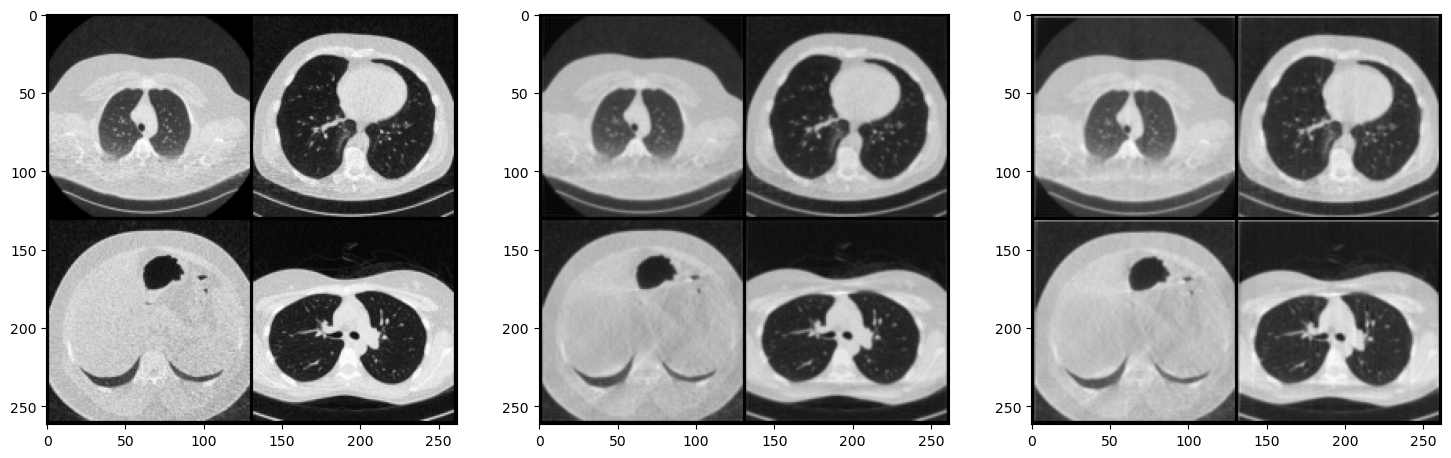

In [48]:
from skimage.exposure import match_histograms
from skimage.transform.radon_transform import _get_fourier_filter, iradon

high, low = next(iter(dl_test))
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
h_sinogram = radon_all.A(high)
l_sinogram = radon_all.A(low)
print(h_sinogram.shape, l_sinogram.shape)
mask = torch.zeros([4, 1, int((128 * (2*torch.ones(1)).sqrt()).ceil()), 180])
mask[..., ::6] = 1
ll_sinogram = l_sinogram
diff = h_sinogram - l_sinogram
print(torch.max(l_sinogram), torch.mean(l_sinogram), torch.min(l_sinogram))
threshold = torch.max(l_sinogram) * 0.7
cond = l_sinogram > threshold
l_sinogram[cond] = threshold
print(torch.max(l_sinogram), torch.mean(l_sinogram), torch.min(l_sinogram))

filtered_sino = np.zeros((4,1,128,128))
for i in range(filtered_sino.shape[0]):
    temp = np.expand_dims(iradon(ll_sinogram[i,0,...].numpy(), circle=False), 0)
    filtered_sino[i,...] = temp
filtered_sino = torch.Tensor(filtered_sino)

# sinogram_full_masked = sinogram_full * mask
# fbp_masked = radon_all.A_filter(sinogram_full_masked)
fbp = radon_all.A_filter(diff)
fbp_cond = radon_all.A_filter(l_sinogram)
# fbp_filtered = radon_all.A_filter(filtered_sino)

plt.figure(figsize=(18,12))
plt.subplot(1,3,1)
plt.imshow(make_grid(low, nrow=2, normalize=True).permute(1,2,0))
# plt.subplot(1,4,2)
# plt.imshow(make_grid(fbp, nrow=2, normalize=True).permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(make_grid(fbp_cond, nrow=2, normalize=True).permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(make_grid(filtered_sino, nrow=2, normalize=True).permute(1,2,0))
plt.show()

# print(torch.max(h_sinogram), torch.mean(h_sinogram), torch.min(h_sinogram))
# print(torch.max(diff), torch.mean(diff), torch.min(diff))

In [8]:
import sde_lib
import torch
sde = sde_lib.VESDE(sigma_min=0.01, sigma_max=291., N=2000)
timesteps = torch.linspace(sde.T, 1e-5, sde.N)
jump = 7
for i in range(sde.N//jump):
    t = timesteps[jump*i]
    # if jump*(i+2) > 2000:
    #     t = timesteps[-1]
    # vec_t = torch.ones(image.shape[0]) * t
# print(t, jump*(i+2))
import numpy as np
np.zeros(sde.N)
# mean = mean + torch.randn_like(mean) * std[:, None, None, None]
# plt.imshow(torchvision.utils.make_grid(image, normalize=True).permute(1,2,0))

array([0., 0., 0., ..., 0., 0., 0.])

In [16]:
import math
import jax.numpy as jnp
import jax
import torch

def expand_diameter(diameter, K):
  expanded_diameter = int(diameter * K)
  if expanded_diameter % 2 == 1:
    expanded_diameter += 1
  return expanded_diameter

def get_ct_subsampling_mask(size, n_angles, expansion):
  diameter = math.ceil(np.sqrt(2.) * size)
  expanded_diameter = expand_diameter(diameter, expansion)
  sampled_row_ids = np.round(np.linspace(0, size - 1, n_angles)).astype(np.int32)
  return jnp.zeros((size, expanded_diameter)).at[sampled_row_ids, :].set(1.)




tensor([1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
        1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05])

torch.Size([4, 1, 128, 128])


/hdd1/anaconda/minhyeok/anaconda3/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


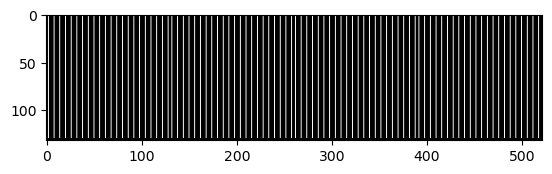

In [4]:
from physics.ct import CT

size = 128
sparsity = 6
num_proj = 180 // sparsity  # 180 / 6 = 30
det_count = int((size * (2*torch.ones(1)).sqrt()).ceil()) # ceil(size * \sqrt{2})

# mask = torch.zeros([4, 1, det_count, 180])
mask = torch.zeros(image.shape)
mask[..., ::sparsity] = 1
print(mask.shape)
plt.imshow(torchvision.utils.make_grid(mask, normalize=True).permute(1,2,0))

# angles = np.linspace(0, np.pi, 180, endpoint=False)
radon = CT(img_width=size, radon_view=num_proj, circle=False)
radon_all = CT(img_width=size, radon_view=180, circle=False)

torch.Size([4, 1, 128, 128])


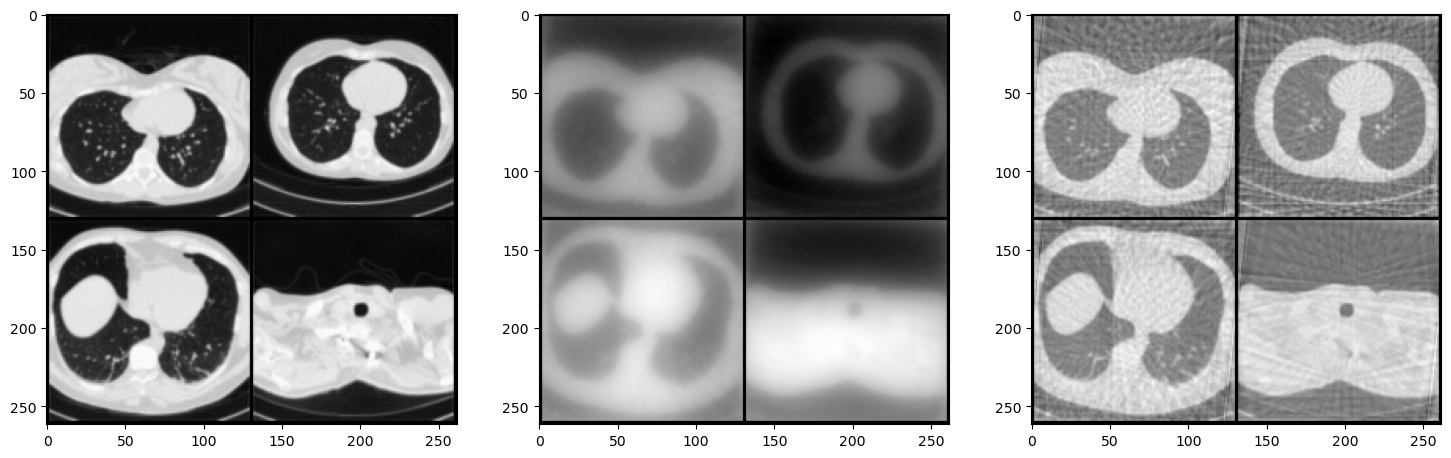

In [54]:
high, low = next(iter(dl_test))
sinogram = radon_all.A(high)
a = radon.A(high)
at = radon.AT(sinogram)
ainv = radon.A_filter(sinogram)
# Dimension Reducing (DR)
# Dimension Preserving (DP)
# FBP
fbp = radon.A_filter(sinogram)
fbp_full = radon_all.A_filter(sinogram)
print(fbp.shape)

plt.figure(figsize=(18,12))
plt.subplot(1,3,1)
plt.imshow(make_grid(fbp_full, nrow=2, normalize=True).permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(make_grid(at, nrow=2, normalize=True).permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(make_grid(ainv, nrow=2, normalize=True).permute(1,2,0))
plt.show()

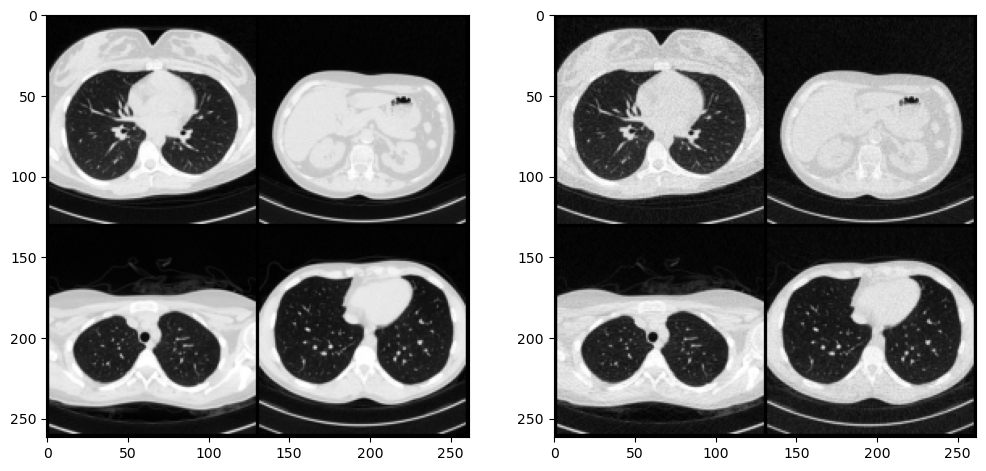

In [20]:
high, low = next(iter(dl_test))

import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(make_grid(high, nrow=2, normalize=True).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(make_grid(low, nrow=2, normalize=True).permute(1,2,0))
plt.show()

torch.Size([4, 1, 128, 128])


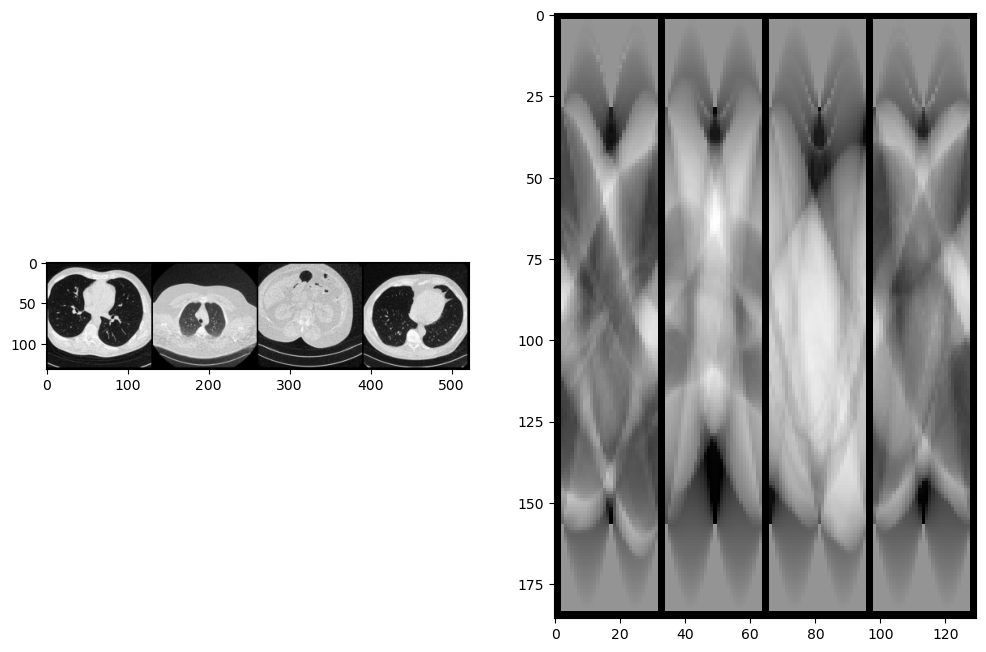

In [8]:
import sde_lib

sde = sde_lib.VESDE(sigma_min=0.01, sigma_max=291., N=2000)
timesteps = torch.linspace(sde.T, 1e-5, sde.N)

vec_t = torch.ones(image.shape[0]) * timesteps[100]

y_mean, std = sde.marginal_prob(low, vec_t)
hat_y = (y_mean + torch.rand_like(y_mean) * std[:, None, None, None]) 
print(hat_y.shape)
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(make_grid(y_mean, normalize=True).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(make_grid(sinogram, normalize=True).permute(1,2,0))
plt.show()

In [56]:
import os

len(os.listdir('/nas/users/sangil/dataset/rsna-2023-abdominal-trauma-detection/segmentations/'))
np.linspace(0, 180, 30, endpoint=False), np.linspace(0, 180, 180, endpoint=False)

(array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
         66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120., 126.,
        132., 138., 144., 150., 156., 162., 168., 174.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115., 116., 117.

In [10]:
from PIL import Image
path='/nas/users/minhyeok/CMH/sde/result/11_17/MCG/pro*'
imglist = glob.glob(path)
imgs = list()
for img in imglist:
    a = Image.open(img)
    imgs.append(a)
imgs[0].save('/nas/users/minhyeok/CMH/sde/result/11_17/MCG/movie.gif', save_all=True, append_images=imgs[1:], duration=3, loop=0)


In [169]:
import glob
len(glob.glob('/nas/dataset/users/minhyeok/LDCT/C*')), len(glob.glob('/nas/dataset/users/minhyeok/LDCT/C*_test'))

(99, 50)

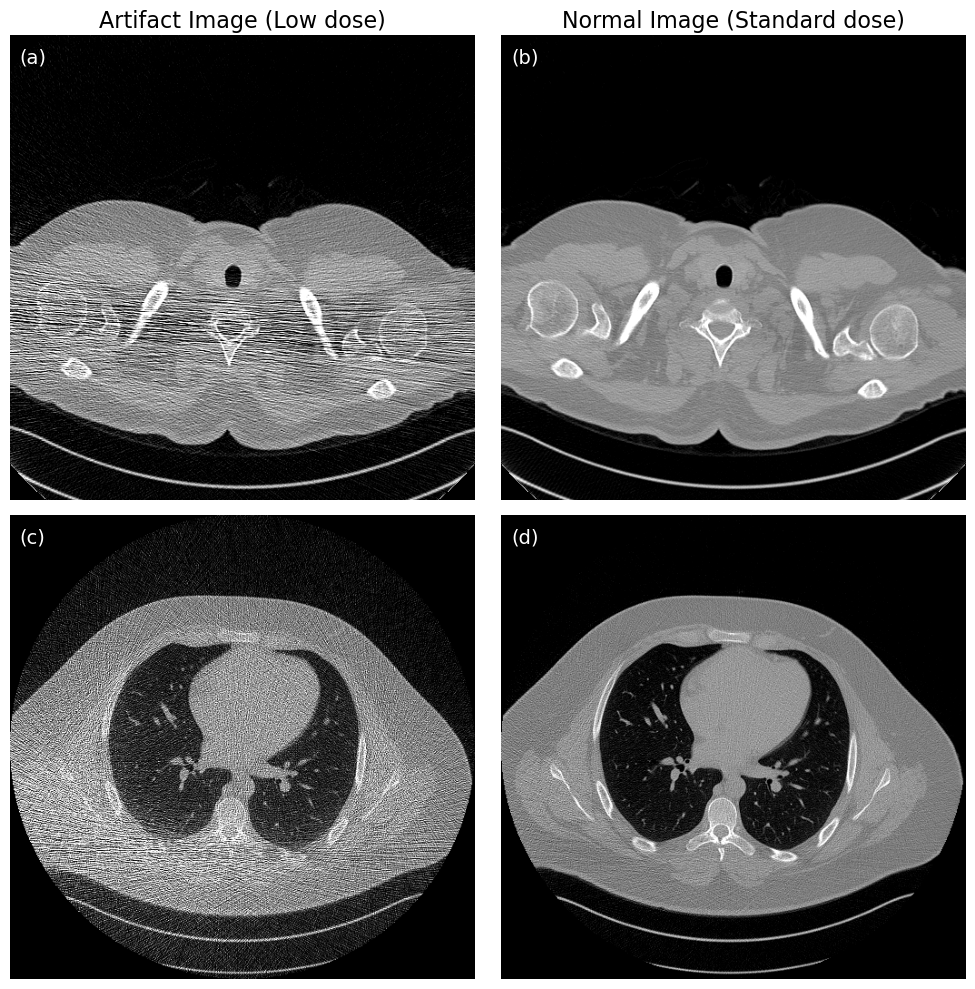

In [109]:
import numpy as np
from PIL import Image

def sitk_resize(sitk_image, size, interpolator=sitk.sitkLinear):
    original_spacing = sitk_image.GetSpacing()
    original_size = sitk_image.GetSize()
    new_size = list(original_size)
    new_size[0]=size
    new_size[1]=size
    new_spacing = [(ospc * osz / nsz) for osz, ospc, nsz in
                   zip(original_size, original_spacing, new_size)]
    sitk_obj = sitk.Resample(sitk_image, new_size, sitk.Transform(), interpolator, 
                               sitk_image.GetOrigin(), new_spacing,
                         sitk_image.GetDirection(), 0, sitk_image.GetPixelID())
    return sitk_obj
def apply_window(path, window_width=1600, window_level=-100):
    a = sitk.ReadImage(path)
    b = sitk.GetArrayFromImage(a)    
    min_value = window_level - 0.5 * window_width
    max_value = window_level + 0.5 * window_width

    windowed_image = np.clip(b, min_value, max_value)

    normalized_image = ((windowed_image - min_value) / (max_value - min_value)*255.0).astype(np.uint8)
    # normalized_image = 2 * (windowed_image - min_value) / (max_value - min_value) - 1
    
    return normalized_image

lowpath1 = '/nas/dataset/users/minhyeok/LDCT/C002_test/Low/1-001.dcm'
highpath1 = '/nas/dataset/users/minhyeok/LDCT/C002_test/Full/1-001.dcm'
# path = '/nas/dataset/users/minhyeok/LDCT/C002_test/Full/1-001.dcm'
lowpath2 = '/nas/dataset/users/minhyeok/LDCT/C030_test/Low/1-150.dcm'
highpath2 = '/nas/dataset/users/minhyeok/LDCT/C030_test/Full/1-150.dcm'

low1=apply_window(lowpath1)
high1 =apply_window(highpath1)
low2=apply_window(lowpath2)
high2 = apply_window(highpath2)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(low1[0], cmap='gray')
plt.title('Artifact Image (Low dose)', fontsize=16)
plt.text(10, 30, '(a)', color='white', fontsize=14)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(high1[0], cmap='gray')
plt.title('Normal Image (Standard dose)', fontsize=16)
plt.axis('off')
plt.text(10, 30, '(b)', color='white', fontsize=14)

plt.subplot(2,2,3)
plt.imshow(low2[0], cmap='gray')
plt.text(10, 30, '(c)', color='white', fontsize=14)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(high2[0], cmap='gray')
plt.axis('off')
plt.text(10, 30, '(d)', color='white', fontsize=14)
plt.tight_layout()
# plt.hist(c.flatten(), bins=256)
# plt.ylim(0,5000)
# plt.subplot(1,2,2)
# plt.imshow(d[0], cmap='gray')
# plt.title('bone setting')
# plt.hist(d.flatten(), bins=256)
# plt.ylim(0,5000)
plt.show()


In [1]:
from UNet_model import UNet
from torchsummary import summary

unet = UNet(1, 32, 1, True).to('cuda')
summary(unet, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             576
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

1024 -1024


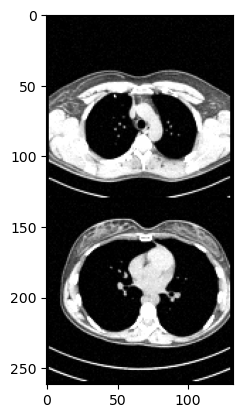

In [34]:
from PIL import Image
import numpy as np
a = Image.open('/nas/users/minhyeok/CMH/sde/result/12_06/cmh/last_image.png').convert("L")
b = np.array(a)
c = (b/255.) * 2048 - 1024
# c = np.clip(c, -1024, 1024)
d = c.astype(np.int16)
print(np.max(d), np.min(d))
import matplotlib.pyplot as plt
def apply_window(image_array, window_width, window_level):
  
  min_value = window_level - 0.5 * window_width
  max_value = window_level + 0.5 * window_width

  windowed_image = np.clip(image_array, min_value, max_value)
  normalized_image = ((windowed_image - min_value) / (max_value - min_value) * 255).astype(np.uint8)

  # normalized_image = 2 * (windowed_image - min_value) / (max_value - min_value) - 1
  return normalized_image
# plt.imshow(d, 'gray')
e = apply_window(d, 2000, -1000)
plt.imshow(e, 'gray')